# ニューラルネットワークの学習

訓練データから適切な重みパラメータを自動で獲得する。
そのため損失関数という指標を導入する。
この損失関数の値が最も小さくなる重みパラメータを探し出す。

損失関数を探すために勾配法と呼ばれる関数の傾きを使った手法を用いる。

## データ駆動

機械学習の中心はデータ

手書き数字を認識する方法の一つ
画像から特徴量を抽出してその特徴量のパターンを機械学習の技術で学習する。
画像の特徴量は通常ベクトルとして記述される。
そのベクトルに対して機械学習で使われる識別器SVMやKNNなどで学習させることができる。

問題ごとにアルゴリズムを考える必要はなくなり、機械が規則性を見つけ出すことにはなったが特徴量は問題ごとに人がケアする必要がある。

ニューラルネットワーク（ディープラーニング）は機械学習で必要だった特徴量の設計もいらない。

> その意味でディープラーニングはend-to-end machine learningよ呼ばれることもある。

手書き数字なのか人の顔なのか犬の種類なのかに関係なく学習しパターンを発見しようとする。

訓練データ（教師データ）とテストデータ

あるデータセットだけに過度に対応した過学習にならないようにすることは機械学習の重要な課題。

## 損失関数

ニューラルネットワークが最適な重みパラメータを求めるのに使う損失関数は任意の関数を用いることができるが、
一般には2乗和誤差や交差エントロピー誤差などが用いられる。

### 2乗和誤差

$$ E = \frac{1}{2} \sum_k (y_k - t_k)^2 $$

$y_k$ はニューラルネットワークの出力、$t_k$は教師データを、$k$はデータの次元数を表す。

In [1]:
import numpy as np

def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t)**2)

In [2]:
# 正解ラベルが1で、それ以外を0で表す表現をone-hot表現という
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t))

0.097500000000000031

In [3]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t))

0.59750000000000003

### 交差エントロピー誤差 (cross entropy error)

$$ E = - \sum_k t_k \log y_k $$

$y_k$がニューラルネットワークの出力、$t_k$が正解ラベル。$t_k$は正解ラベルとなるインデックスのみ1で、他は0とする(one-hot表現)。
つまり正解ラベルが1に対応する出力の自然対数を計算することになる。

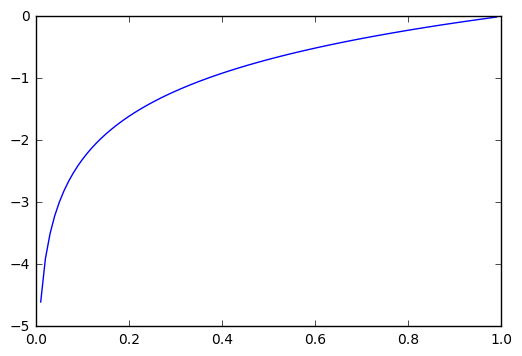

In [9]:
import matplotlib.pyplot as plt

x = np.arange(0.01, 1.0, 0.01)
y = np.log(x)

plt.plot(x, y)
plt.xlim(0, 1)
plt.show()

In [10]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta)) # np.log(0)はinfとなり計算が止まるため、微小な値を足す

In [11]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.51082545709933802

In [12]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.3025840929945458

### ミニバッチ学習

訓練データが100個あれば、その100個の損失関数の和と指標とする。
訓練データすべての損失関数の和を求める場合、交差エントロピー誤差では以下のようになる。

$$ E = - \frac{1}{N} \sum_n \sum_k t_{nk} \log y_{nk} $$

訓練データがビッグデータの場合などは数百万などになり、それらすべてを対象に損失関数を計算するのは現実的ではないのでデータの中の一部を選び出しそこを全体の近似として利用する。
これをミニバッチ学習という。

In [14]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

x_train.shape, t_train.shape

((60000, 784), (60000, 10))

In [17]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

batch_mask

array([11468, 24396, 26661, 33197, 58335,  3903, 30917, 39241,  9185, 48800])

In [19]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

### なぜ損失関数を設定するのか？

文字認識などでは認識精度を指標にすれば良いように思われる。これは指標の勾配を利用して重みパラメータを決定するためで、例えば認識率32％のニューラルネットワークのある重みパラメータを変えても32%になった場合、それが良かったのかわからない。
損失関数であれば値は微小でも変化し、その変化を元に重みパラメータを＋か-かに変化させることができる。

ステップ関数も同様で、これはある瞬間だけ変化を起こす関数だが、シグモイド関数はどの場所でも微分が0にならないためニューラルネットワークの学習においては重要な性質となる。

## 数値微分

勾配法では勾配の情報で進む方向を決める。

### 微分

微分とはある瞬間の変化の量を表したもので、次の式で定義される。

$$ \frac{df(x)}{dx} = \lim_{h to 0} \frac{f(x + h) - f(x)}{h} $$

In [20]:
# 悪い実装例
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

In [21]:
# h が小さすぎる。10^-4程度であれば良い結果が得られることがわかっている。
# x と (x + h) の間の傾きが実際のxの時点での傾きと誤差を持つ。そこで、(x + h)と(x - h)の微分を行う。（中心差分）
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x - h)) / (2 * h)

In [22]:
# 微小な差分で微分を求めることを数値微分(numerical differentiation)という。
# 数式の展開によるものは解析的(analytic)という言葉を用いる。

# y = 0.01x^2 + 0.1x
def function_1(x):
    return 0.01*x**2 + 0.1*x

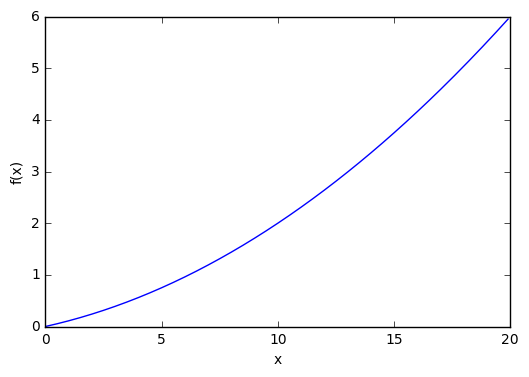

In [23]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(x, y)
plt.show()

In [24]:
numerical_diff(function_1, 5)

0.1999999999990898

In [25]:
numerical_diff(function_1, 10)

0.2999999999986347

0.1999999999990898
0.2999999999986347


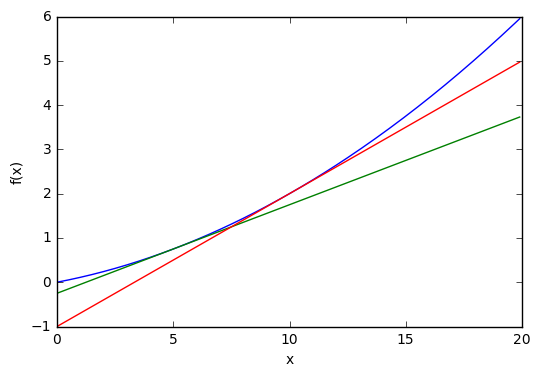

In [31]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(x, y)


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

tf1 = tangent_line(function_1, 5)
tf2 = tangent_line(function_1, 10)
plt.plot(x, tf1(x))
plt.plot(x, tf2(x))
plt.show()

### 偏微分

$$ f(x_0, x_1) = x_0^2 + x_1^1 $$

複数の変数からなる関数の微分を偏微分という。

In [32]:
def function_2(x):
    return x[0]**2 + x[1]**2 ## or np.sum(x**2)

In [35]:
# x0 = 3, x1 = 4のときのx0に対する偏微分
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [36]:
# x0 = 3, x1 = 4のときのx1に対する偏微分

def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

$x_0$, $x_1$の偏微分をまとめて計算する。 $(\frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1})$のようにすべての変数の偏微分をベクトルとしてまとめたものを勾配という。

In [37]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # x と同じ形状の配列を生成
    
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x + h)
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x - h)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

In [38]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([ 6.,  8.])

In [39]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([ 0.,  4.])

In [40]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([ 6.,  0.])

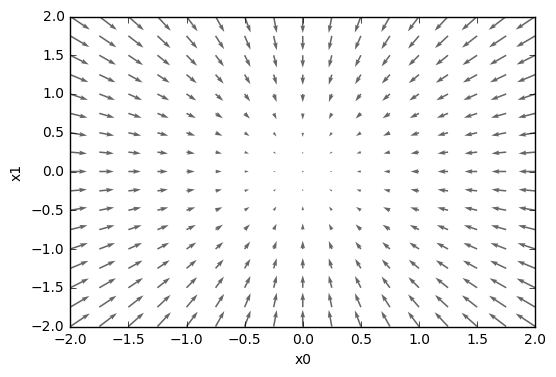

In [45]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.draw()
plt.show()
# この勾配が関数の値を最も減らす方向を向いている！